# MODIS Climate Marble
      Date                        Description
    02/27/2018            Set up the main framework.
    02/28/2018            The main framework is set.
    03/12/2018            Daily results are all set and process the monthly means. 

### I. Framework

The whole project is based on the existing codes. The MODIS relevant documents can be found https://mcst.gsfc.nasa.gov/content/l1b-documents. 

I think the final MODIS climate marble should be based on the global view from each day. This approach also should benefit the moving average to get 365 pics. 

One question come up, how to deal with the sun glint region? Like MISR, I didn't do anything for that. Will it contribute to the evident bright stripe?

In [ ]:
# taking MOD021KM.A2013198.0210.hdf as an example


# Import
from zyz_core import np, plt, os, time, tqdm
from zyz_data import MOD02_select_chs, MOD02_retrieve_field
from zyz_plot import draw_modis_enhanced_RGB


working_dir = '/Users/yizhe/OneDrive - University of Illinois - Urbana/test_MODIS_ClimateMarble/MODIS_20180112'


### II. Main function

    If we want to make VZA < 30°, the vza index range should be [70, 201];
    If we want to make VZA < 40°, the vza index range should be [48, 223].

In [ ]:

def main_process_single_MOD02file(mod_file_dir):

    # We may want to retrieve VZA first and apply a criterion on it (need to be tested). 
    # Here we do not consider the VZA field.
    vza = MOD02_retrieve_field(mod_file_dir, 'SensorZenith')[:]/100.
    

    # Reading Lat/Lon and the radiance data.
    lats = MOD02_retrieve_field(mod_file_dir, 'Latitude')[:]
    lons = MOD02_retrieve_field(mod_file_dir, 'Longitude')[:]
    ch1 = MOD02_select_chs(mod_file_dir, [1])[:, :, 0]
    rad_shape = ch1.shape
    ch1_1d = ch1.ravel()


    # Assumption 1: repeat lats and lons 5 times to fit the radiance dimensions
    lats_new = np.repeat(np.repeat(lats, 5, axis=0), 5, axis=1)[:rad_shape[0], : rad_shape[1]]
    lons_new = np.repeat(np.repeat(lons, 5, axis=0), 5, axis=1)[:rad_shape[0], : rad_shape[1]]
    lats_float_1d = lats_new.ravel()
    lons_float_1d = lons_new.ravel()
    lats_int_1d = lats_float_1d.astype('int32')
    lons_int_1d = lons_float_1d.astype('int32')
    lats_decimal_1d = lats_float_1d - lats_int_1d
    lons_decimal_1d = lons_float_1d - lons_int_1d
#     print lats_float_1d, lats_int_1d, lats_decimal_1d

    # We have a global grid of 1 degree resolution (180*360), the corresponding indexes are showing below
    #                  0 (90 ~ 89)
    #    0(-180 ~ -179)          359(179 ~ 180)
    #                180 (89 ~ 90)
#     global_radiance_sum = np.zeros((180, 360))
#     global_radiance_num = np.zeros((180, 360))

    # The following part is just sorting the radiances into lat/lon bins. 
    # For example, if a FOV's lat(lon) is 38.3(118.2), it should belong to the bin of (38°N--39°N) and (118°E--119°E),
    # which corresponds to the y index of (90-38=52) and to the x index of (118+180=298). So, we just need to add the 
    # radiance to variable global_radiance_sum[52, 298] and add 1 to the variable global_radiance_sum[52, 298].
#     for irad, ilat, ilon in zip(ch1_1d, lats_int_1d, lons_int_1d):
#         y_idx = 90 - ilat
#         x_idx = 180 + ilon
#         global_radiance_sum[y_idx, x_idx] += irad
#         global_radiance_num[y_idx, x_idx] += 1


    # Now, what if we use 0.5 degree resolution (360*720), the corresponding indexes are showing below
    #                  0 (90 ~ 89.5)
    #    0(-180 ~ -179.5)          719(179.5 ~ 180)
    #                360 (89.5 ~ 90)
    global_radiance_sum = np.zeros((360, 720))
    global_radiance_num = np.zeros((360, 720))

    # The following part is just sorting the radiances into lat/lon bins. 
    # For example, if a FOV's lat(lon) is 38.3(118.2), it should belong to the bin of (38°N--38.5°N) and (118°E--118.5°E).
    # It is slightly more complicated as we need to deal with 0.5 degree.
    for irad, ilat_dcm, ilon_dcm, ilat_int, ilon_int in zip(ch1_1d, lats_decimal_1d, lons_decimal_1d, lats_int_1d, lons_int_1d):
        if (irad > 1000) or (irad < 5):
            continue
            
        y_idx = 90 - ilat_int
        x_idx = 180 + ilon_int
        
        if abs(ilat_dcm) < 0.5:
            y_idx = y_idx * 2
        else:
            y_idx = y_idx * 2 + 1
        
        if abs(ilon_dcm) < 0.5:
            x_idx = x_idx * 2
        else:
            x_idx = x_idx * 2 + 1
        
        global_radiance_sum[y_idx, x_idx] += irad
        global_radiance_num[y_idx, x_idx] += 1


    return global_radiance_sum, global_radiance_num




### III. Process

In [ ]:


global_radiance_sum = np.zeros((360, 720))
global_radiance_num = np.zeros((360, 720))
    
files = os.listdir(working_dir)
    
for imod_file in tqdm(files, miniters=10):
    if imod_file.startswith('MOD021KM'):
#         t0 = time.time()
#         print imod_file
        mod_file_dir = os.path.join(working_dir, imod_file)

        tmp_rad_sum, tmp_rad_num = main_process_single_MOD02file(mod_file_dir)

        global_radiance_sum += tmp_rad_sum
        global_radiance_num += tmp_rad_num
#         print time.time() - t0


### IV. Show results

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(global_radiance_sum/global_radiance_num, vmax=400)
# plt.colorbar()
plt.savefig('test.png', dpi=300)
plt.show()

### 03/12/2018

1) 创建每年的文件夹并将相应年份的数据存入

In [ ]:
from zyz_core import np, os


data_dir = os.path.join("/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily/", 'LW_P2')

# Step 1
for iyr in range(2000, 2016):
    os.mkdir(os.path.join(data_dir, str(iyr)))


# Step 2
for ifile in os.listdir(data_dir):
#     print ifile
    if ifile.endswith('.npz') == False:
        continue
    file_0 = os.path.join(data_dir, ifile)
    
    iyr = ifile[:4]
    file_1 = os.path.join(os.path.join(data_dir, iyr), ifile)
    os.rename(file_0, file_1)

2) 对每年数据按月划分，区分闰年2000, 2004, 2008, 2012  
这块内容参见目录下的split_by_month.py, 生成的月平均数据存在scratch/results/monthly目录下

### 03/13/2018

3) 对月平均数据进行处理，得到16年（2000--2015）每个月的平均值。输出为12个文件。

In [ ]:
cats = ['VIS', 'SWIR_P1', 'SWIR_P2', 'LW_P1', 'LW_P2']


working_dir = '/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily/'
output_dir = '/u/sciteam/smzyz/scratch/results/'

for icat in cats[3:]:
    # iterating each month and collect available monthly mean results of the specified category.
    for imon in tqdm(range(1, 13), miniters=1):

        rad_all = np.zeros((1800, 3600, 8))
        num_all = np.zeros((1800, 3600, 8))
        for iyr in range(2000, 2016):
            ifile = "{}_{}_{}.npz".format(icat, iyr, imon)
            inpz = np.load(os.path.join(working_dir, ifile))

            rad_all += inpz['rad_all']
            num_all += inpz['num_all']

        mean_rad = np.array(rad_all / num_all)

        np.savez_compressed(os.path.join(output_dir, "{}_{}.npz".format(icat, imon)), mean_rad = mean_rad)

In [ ]:

from zyz_core import np, os, tqdm

working_dir = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily/"
output_dir = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily_mean/"

cats = ['VIS', 'SWIR_P1', 'SWIR_P2', 'LW_P1', 'LW_P2']

for icat in cats[:1]:
    # iterating each month and collect available monthly mean results of the specified category.
    for iday in tqdm(range(1, 367), miniters=1):
        
        if icat in ['VIS', 'SWIR_P2']:
            rad_all = np.zeros((3600, 7200, 7))
            num_all = np.zeros((3600, 7200, 7))
        else:
            rad_all = np.zeros((3600, 7200, 8))
            num_all = np.zeros((3600, 7200, 8))
            
        for iyr in range(2000, 2016):
            ifile = "{}.{}.npz".format(iyr, str(iday).zfill(3))
            try:
                inpz = np.load(os.path.join(working_dir+"{}/{}".format(icat, iyr), ifile))

                rad_all += inpz['rad_sum']
                num_all += inpz['rad_num']
            except Exception as err:
                print "Error: {}".format(err)

        mean_rad = np.array(rad_all / num_all)

        np.savez_compressed(os.path.join(output_dir, "{}_{}.npz".format(icat, str(iday).zfill(3))), mean_rad = mean_rad)

In [ ]:
from postprocess_climate_by_runningmean import monthly_mean_rewrite_netCDF4

monthly_mean_rewrite_netCDF4('LW_P2')

### 03/15/2018

遍历文件夹，输出文件数量。

In [ ]:
import numpy as np
import os


cnt = []
tot = 0
for iyr in range(2000, 2016):
    path = '/u/sciteam/smzyz/scratch/results/VIS/{}'.format(iyr)
    
    files = os.listdir(path)
    print len(files)
    
#     for iday in range(1, 367):
#         path_1 = os.path.join(path, str(iday).zfill(3))
        
#         try:
#             files = os.listdir(path_1)
#         except OSError as err:
#             continue
            
#         for ifile in files:
#             if ifile.endswith('.hdf'):
#                 cnt.append(os.path.join(path_1, ifile))
        
#         print len(cnt) - tot
#     tot = len(cnt)

In [ ]:
from zyz_core import h5py


npz_file = '/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_01deg/daily/VIS/2000/2000.061.npz'

data = np.load(npz_file)
rad_sum = data['rad_sum']
rad_num = data['rad_num']



h5_file = '/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_01deg/daily/VIS/2000/2000.061.h5'

with h5py.File(h5_file, 'a') as h5f:
    h5f.create_dataset('/rad_sum', data=rad_sum, compression='gzip', compression_opts=9)
    h5f.create_dataset('/rad_num', data=rad_num, compression='gzip', compression_opts=9)

In [ ]:
90*20 - (int(-0.782/0.05))

In [ ]:

def latlon_to_idx(lat_int, lat_decimal, lon_int, lon_decimal, num):
    """
    num: 1/resolution
    """
    # Latitude part
    if lat_int + lat_decimal < 0:
        idx_lat = (90 - lat_int) * num - int(lat_decimal * num)
    else:
        idx_lat = (90 - lat_int) * num - int(lat_decimal * num) - 1
        
    # Longitude part
    if lon_int + lon_decimal < 0:
        idx_lon = (180 + lon_int) * num + int(lon_decimal * num) - 1
    else:
        idx_lon = (180 + lon_int) * num + int(lon_decimal * num)
    
    return int(idx_lat), int(idx_lon)
        
    

In [ ]:
from helper_func import *
import sys


SPATIAL_RESOULITON = 0.05
NUM_POINTS = 1/SPATIAL_RESOULITON
NUM_LATS = int(180/SPATIAL_RESOULITON)
NUM_LONS = int(360/SPATIAL_RESOULITON)
NUM_CHAN = 7 # 15 # 16
CATEGORY = 1 # 2 # 3



# mod_file_dir = '/u/sciteam/smzyz/scratch/data/MODIS/MOD021KM/2000/100/MOD021KM.A2000100.0010.006.2014230132236.hdf'
def main_process_single_MOD02file(mod_file_dir):

    # We may want to retrieve VZA first and apply a criterion on it (need to be tested).    
    BOUNDING_LOW_VZA = 48#28 #48 #70
    BOUNDING_HIG_VZA = 233#242 #233 #201


    # Read Lat/Lon.
    lats = MOD02_retrieve_field(mod_file_dir, 'Latitude')[:, BOUNDING_LOW_VZA:BOUNDING_HIG_VZA]
    lons = MOD02_retrieve_field(mod_file_dir, 'Longitude')[:, BOUNDING_LOW_VZA:BOUNDING_HIG_VZA]
    geo_shape = lats.shape

        
    # Read radiances and resample into coarser resolution (5 km).
    rads, max_values = MOD02_retrieve_radiance_all(mod_file_dir, CATEGORY)
    rads_1km = rads[:, BOUNDING_LOW_VZA*5:BOUNDING_HIG_VZA*5]
    rads_5km = np.array([[rads_1km[j*5:(j+1)*5, i*5:(i+1)*5, :].mean(axis=1).mean(axis=0) 
                                for i in range(geo_shape[1])] for j in range(geo_shape[0])])
    rads_shape = rads_5km.shape
    
    # Calculate Lat/Lon integers and decimals, which will be used as indexes later. 
    lats_int_2d = lats.astype('int32')
    lons_int_2d = lons.astype('int32')
    lats_decimal_2d = lats - lats_int_2d
    lons_decimal_2d = lons - lons_int_2d

    
    # Now, what if we use 0.1 degree resolution (1800*3600), the corresponding indexes are showing below
    global_radiance_sum = np.zeros((NUM_LATS, NUM_LONS, NUM_CHAN))
    global_radiance_num = np.zeros((NUM_LATS, NUM_LONS, NUM_CHAN))
 

    # The following part is just sorting the radiances into lat/lon bins. 
    for i in range(geo_shape[0]):
        for j in range(geo_shape[1]):
            
            if (lats_int_2d[i, j]==-999) | (lons_int_2d[i, j]==-999) | (lats[i, j]>lats[i-1, j]):
                continue
                
            # Calculate index for x and y.
            y_idx, x_idx = latlon_to_idx(lats_int_2d[i, j], lats_decimal_2d[i, j], 
                                         lons_int_2d[i, j], lons_decimal_2d[i, j],
                                         NUM_POINTS)
        
            # 
            rads_5km_new = [0 if rad>rad_max else rad for rad, rad_max in zip(rads_5km[i, j, :], max_values)]
            number_new = [1 if rad>0 else 0 for rad in rads_5km_new]

            global_radiance_sum[y_idx, x_idx, :] += rads_5km[i, j, :]
            global_radiance_num[y_idx, x_idx, :] += number_new
        
    return global_radiance_sum, global_radiance_num

In [ ]:
import numpy as np
import os
from tqdm import tqdm

yrs = [2003]
for iyr in yrs:
        data_folder = "/u/sciteam/smzyz/scratch/results/VIS/{}".format(iyr)
    
        rad_all = np.zeros((3600, 7200, 7))
        num_all = np.zeros((3600, 7200, 7))
    
        files = os.listdir(data_folder)
        length = len(files)
    
        for i in tqdm(range(length), miniters=10):
            ifile = files[i]
        
            if ifile.endswith('.npz') == False:
                continue
        
            fnpz = np.load(os.path.join(data_folder, ifile))
            tmp_rad = fnpz['rad_sum'][:]
            tmp_num = fnpz['rad_num'][:]
        
            rad_all += tmp_rad
            num_all += tmp_num

        np.savez("/u/sciteam/smzyz/{}".format(iyr), rad_all=rad_all, num_all=num_all)

## False color composite images test (April 5, 2018)  

In [1]:
from my_module import np, os, Dataset, plt, toimage

from my_module.plot import enhance_rgb


/mnt/bwpy/single/usr/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def retrieve_monthly_climate_by_band(iband):
    
    data_folder = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/monthly_mean_nc"
    data_file = os.path.join(data_folder, 'monthly_climate_band_{}.nc'.format(iband))
    
    ncdf = Dataset(data_file)
    data = ncdf.variables['mean_radiance'][:]
    np.place(data, data<0, 0)
    return data


r = retrieve_monthly_climate_by_band(32)-retrieve_monthly_climate_by_band(31)
g = retrieve_monthly_climate_by_band(31)-retrieve_monthly_climate_by_band(29)
b = retrieve_monthly_climate_by_band(31)


#### Default  
_coeff_ is the maximum value of blue band;  
_scale method_ is discrete;  
_scale factors_ are not used;

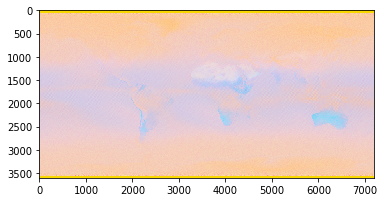

In [3]:
rgb = np.dstack((r[0], g[0], b[0]))
en_rgb = enhance_rgb(rgb)
plt.imshow(en_rgb)
plt.show()

#### RLT, trial 1  
_coeff_ is the maximum value of blue band;  
_scale method_ is RLT;  
_scale factors_ are [1, 1, 1];

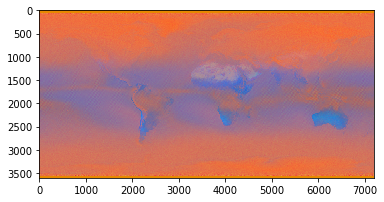

In [4]:
# RLT but not set scale_factors
en_rgb = enhance_rgb(rgb, scale_method='RLT')
plt.imshow(en_rgb)
plt.show()

#### RLT, trial 2 
_coeff_ is the maximum value of blue band;  
_scale method_ is RLT;  
_scale factors_ are [1, 1.2, 1];

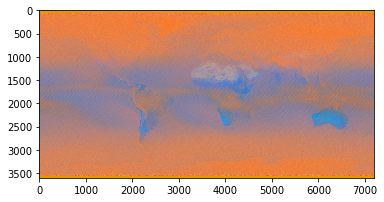

In [6]:
# RLT and set scale_factors
en_rgb = enhance_rgb(rgb, scale_method='RLT', scale_factors=[1, 1.2, 1])
plt.imshow(en_rgb)
plt.show()

## Running mean test (April 6, 2018)  
Try calculating the moving average (finally get 365 images) based on the climatic daily mean values.  
This part belongs to the "process".  
The op. code will be named as "postprocess_running_mean.py" and saved to "process" folder.

In [47]:
from my_module import np, os, tqdm

daily_mean_folder = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily_mean"

#### Try on band 1  
Basically there should be a function fulfills the following criterion:  
1) a parameter stores the data folder: data_folder  
2) a parameter stores the user defined band: iband  
3) a parameter stores the number of running window: num_window  
4)* an array with the same size (3) stores the filter: iflter (default is [])  
5) the output should contain 365 (or 366?) images with the same shape array: avg_moving

In [115]:
# 预备工作
data_folder = daily_mean_folder
iband = 1
num_window = 61 # should be an odd number


#
def get_fname_bandindex(iband):
    
    iband = str(iband)
    
    # predefined categories
    VIS = np.array([1, 2, 3, 4, 5, 6, 7], dtype=str)
    SWIR_P1 = np.array([8,9,10,11,12,'13lo','13hi','14lo'], dtype=str)
    SWIR_P2 = np.array(['14hi',15,16,17,18,19,26], dtype=str)
    LW_P1 = np.array([20,21,22,23,24,25,27,28], dtype=str)
    LW_P2 = np.array([29,30,31,32,33,34,35,36], dtype=str)
    
    # retrieve the index of band in a specified category as well as the data file
    if iband in VIS:
        ifile = "VIS_{}.npz"
        iband_idx = np.where(iband==VIS)[0][0]
    elif iband in SWIR_P1:
        ifile = "SWIR_P1_{}.npz"
        iband_idx = np.where(iband==SWIR_P1)[0][0]
    elif iband in SWIR_P2:
        ifile = "SWIR_P2_{}.npz"
        iband_idx = np.where(iband==SWIR_P2)[0][0]
    elif iband in LW_P1:
        ifile = "LW_P1_{}.npz"
        iband_idx = np.where(iband==LW_P1)[0][0]
    elif iband in LW_P2:
        ifile = "LW_P2_{}.npz"
        iband_idx = np.where(iband==LW_P2)[0][0]
    
    return ifile, iband_idx


# 
def get_process_days(iday, num_window):
    # successsive 3 years
    _days_3yrs = np.append(np.append(range(1, 366), range(1, 366)), range(1, 366)) 
    # given a day (iday) as the central day, the required processing days are
    process_days = _days_3yrs[365+iday-(num_window-1)/2-1:365+iday+(num_window-1)/2]
    
    return process_days


# main function, process one time moving average
def main_process_one_time(iband, iday, num_window):
    
    # 1. use get_fname_bandindex to retrieve fname and band_idx
    fname, band_idx = get_fname_bandindex(iband)
    
    # 2. use get_process_days to retrieve process_days
    process_days = get_process_days(iday, num_window)
    
    # 3. do process
    sum_moving = np.zeros((3600, 7200))
    for iday in process_days:
        print iday
        data_file = fname.format(str(iday).zfill(3))
        data_path = os.path.join(data_folder, data_file)
        data = np.load(data_path)['mean_rad'][:, :, band_idx]
        sum_moving = np.nansum([sum_moving, data], axis=0)

    avg_moving = np.nan_to_num(sum_moving / iday)
    toimage(avg_moving).save("avg_moving_{}_{}.png".format(iband, iday))

In [116]:
main_process_one_time(iband, 1, 31)

351


ValueError: could not broadcast input array from shape (3600,7200,7) into shape (3600,7200)

__test 1__: how many days (1 band) can we store in a single array?  
__answer 1__: ~20  
__test 2__: how many nodes (cores) are required to finish this task?  
__answer 2__: To maximize the utility of usage, ...  
__test 3__: should I implement the feature allowing filter input?  
__answer 3__: Yes  

In [70]:
fname, band_idx = get_fname_bandindex(iband)

tmp_array = np.zeros((3600, 7200))
for iday in range(1, 367):
    data_file = fname.format(str(iday).zfill(3))
    data_path = os.path.join(data_folder, data_file)
    data = np.load(data_path)['mean_rad'][:, :, band_idx]
    tmp_array = np.nansum([tmp_array, data], axis=0)
    
    data_new = np.nan_to_num(tmp_array/iday)
    toimage(data_new).save("{}.png".format(iday))
    

  0%|          | 0/307 [00:00<?, ?it/s]/mnt/bwpy/single/usr/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # This is added back by InteractiveShellApp.init_path()
 38%|███▊      | 117/307 [1:00:06<1:37:37, 30.83s/it]

KeyboardInterrupt: 

In [58]:
from my_module import plt, toimage